In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np

In [3]:
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.layers import Input, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D, Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras import layers

In [4]:
training_set=tf.keras.utils.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 70295 files belonging to 38 classes.


In [5]:
validation_set=tf.keras.utils.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 17572 files belonging to 38 classes.


In [6]:
training_set

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 38), dtype=tf.float32, name=None))>

In [7]:
from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stopping = EarlyStopping(
                                patience=5,
                                min_delta = 0.01,
                                verbose=1,
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3,
                                    episilon= 0.01,
                                    factor=0.1,
                                    cooldown = 4,
                                    verbose=1)

time_callback = TimingCallback()

In [9]:
n_class=38

base_model=tf.keras.applications.MobileNetV3Large(
    input_shape=(128,128,3),
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
)

for layer in base_model.layers: 
    layer.trainable = False
    
model=Sequential()

In [10]:
model.add(base_model)
model.add(GlobalAveragePooling2D()) 
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(n_class, activation='softmax'))

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 4, 4, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              984064    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [13]:
batch_size = 128
epochs = 20 
model_history = model.fit(
            training_set,
            validation_data =validation_set,
            epochs = epochs,
            callbacks = [
                         reduce_learning_rate,
                         early_stopping,
                         time_callback
                        ],
            verbose=True)

Epoch 1/20
2197/2197 [==============================] - 414s 184ms/step - loss: 0.3600 - acc: 0.8860 - val_loss: 0.1507 - val_acc: 0.9505 - lr: 0.0010
Epoch 2/20
2197/2197 [==============================] - 307s 139ms/step - loss: 0.1742 - acc: 0.9434 - val_loss: 0.1270 - val_acc: 0.9583 - lr: 0.0010
Epoch 3/20
2197/2197 [==============================] - ETA: 0s - loss: 0.1026 - acc: 0.9686
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2197/2197 [==============================] - 310s 141ms/step - loss: 0.1026 - acc: 0.9686 - val_loss: 0.1324 - val_acc: 0.9616 - lr: 0.0010
Epoch 6/20
2197/2197 [==============================] - 355s 162ms/step - loss: 0.0265 - acc: 0.9910 - val_loss: 0.0694 - val_acc: 0.9806 - lr: 1.0000e-04
Epoch 8/20
1922/2197 [=========================>....] - ETA: 34s - loss: 0.0147 - acc: 0.9948
Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
2197/2197 [==============================] - 313s 143ms/step 

In [14]:
model.save("Plant Recongnition_MobileNet_Mustafa_v3.keras")

In [15]:
model_history.history

{'loss': [0.36004337668418884,
  0.17423641681671143,
  0.13985809683799744,
  0.11794393509626389,
  0.10258425027132034,
  0.043553005903959274,
  0.026460295543074608,
  0.019527200609445572,
  0.01806623861193657,
  0.014289825223386288,
  0.010627222247421741],
 'acc': [0.8860374093055725,
  0.9434099197387695,
  0.9548332095146179,
  0.9620172381401062,
  0.9686037302017212,
  0.9859022498130798,
  0.990980863571167,
  0.9930009245872498,
  0.9938687086105347,
  0.9950352311134338,
  0.9963582158088684],
 'val_loss': [0.1506638377904892,
  0.12700185179710388,
  0.2219965010881424,
  0.14119048416614532,
  0.1324046552181244,
  0.076414093375206,
  0.06938006728887558,
  0.07047560811042786,
  0.07061666995286942,
  0.07095052301883698,
  0.07153140753507614],
 'val_acc': [0.9505463242530823,
  0.958285927772522,
  0.9367175102233887,
  0.958285927772522,
  0.961586594581604,
  0.9783177971839905,
  0.9805940985679626,
  0.9810494184494019,
  0.9815616011619568,
  0.9826997518539

In [16]:
max=len(model_history.history['loss'])+1
epochs=[i for i in range(1,max)]
epochs

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [17]:
classes=validation_set.class_names
classes

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [18]:
test_set=tf.keras.utils.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 17572 files belonging to 38 classes.


In [19]:
y_pred=model.predict(test_set)
print(y_pred)
print(y_pred.shape)


550/550 [==============================] - 81s 142ms/step
[[9.99999940e-01 5.81377448e-13 2.10811243e-10 ... 1.13355455e-23
  3.41947321e-26 1.05480593e-21]
 [9.99999940e-01 2.14516888e-14 2.07222282e-12 ... 3.77936866e-27
  5.64058651e-30 2.08425792e-23]
 [9.99999940e-01 1.68363706e-14 2.37960607e-09 ... 7.50673159e-23
  8.68081260e-27 3.53805879e-19]
 ...
 [1.58812231e-20 5.32735919e-22 8.13357434e-23 ... 9.97043980e-24
  3.24719268e-24 1.00000000e+00]
 [3.09506633e-17 2.66582341e-18 1.34756486e-20 ... 1.44830940e-20
  3.53617189e-18 1.00000000e+00]
 [9.54617133e-18 5.56540765e-18 4.04993142e-24 ... 5.84869660e-25
  1.75798098e-17 1.00000000e+00]]
(17572, 38)


In [20]:
y_pred_argmax=tf.argmax(y_pred,axis=1)
y_pred_argmax

<tf.Tensor: shape=(17572,), dtype=int64, numpy=array([ 0,  0,  0, ..., 37, 37, 37], dtype=int64)>

In [21]:
actual_class=tf.concat([y for x,y in test_set],axis=0)
actual_class

<tf.Tensor: shape=(17572, 38), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>

In [22]:
y_true_argmax=tf.argmax(actual_class,axis=1)

In [23]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics

print(metrics.classification_report(y_true_argmax,y_pred_argmax))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       504
           1       0.98      0.99      0.99       497
           2       0.99      1.00      0.99       440
           3       0.99      0.99      0.99       502
           4       0.99      0.99      0.99       454
           5       1.00      1.00      1.00       421
           6       1.00      1.00      1.00       456
           7       0.97      0.94      0.96       410
           8       1.00      1.00      1.00       477
           9       0.95      0.97      0.96       477
          10       1.00      1.00      1.00       465
          11       0.95      1.00      0.98       472
          12       1.00      0.95      0.97       480
          13       1.00      1.00      1.00       430
          14       1.00      1.00      1.00       423
          15       1.00      0.99      1.00       503
          16       0.99      0.99      0.99       459
          17       0.99    

In [24]:
cnf_matrix=confusion_matrix(y_true_argmax,y_pred_argmax)
display(cnf_matrix)
print(cnf_matrix.shape)

array([[497,   3,   1, ...,   0,   0,   0],
       [  1, 494,   0, ...,   0,   0,   0],
       [  2,   0, 438, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 479,   1,   1],
       [  0,   0,   0, ...,   0, 442,   0],
       [  0,   0,   0, ...,   0,   0, 475]], dtype=int64)

(38, 38)


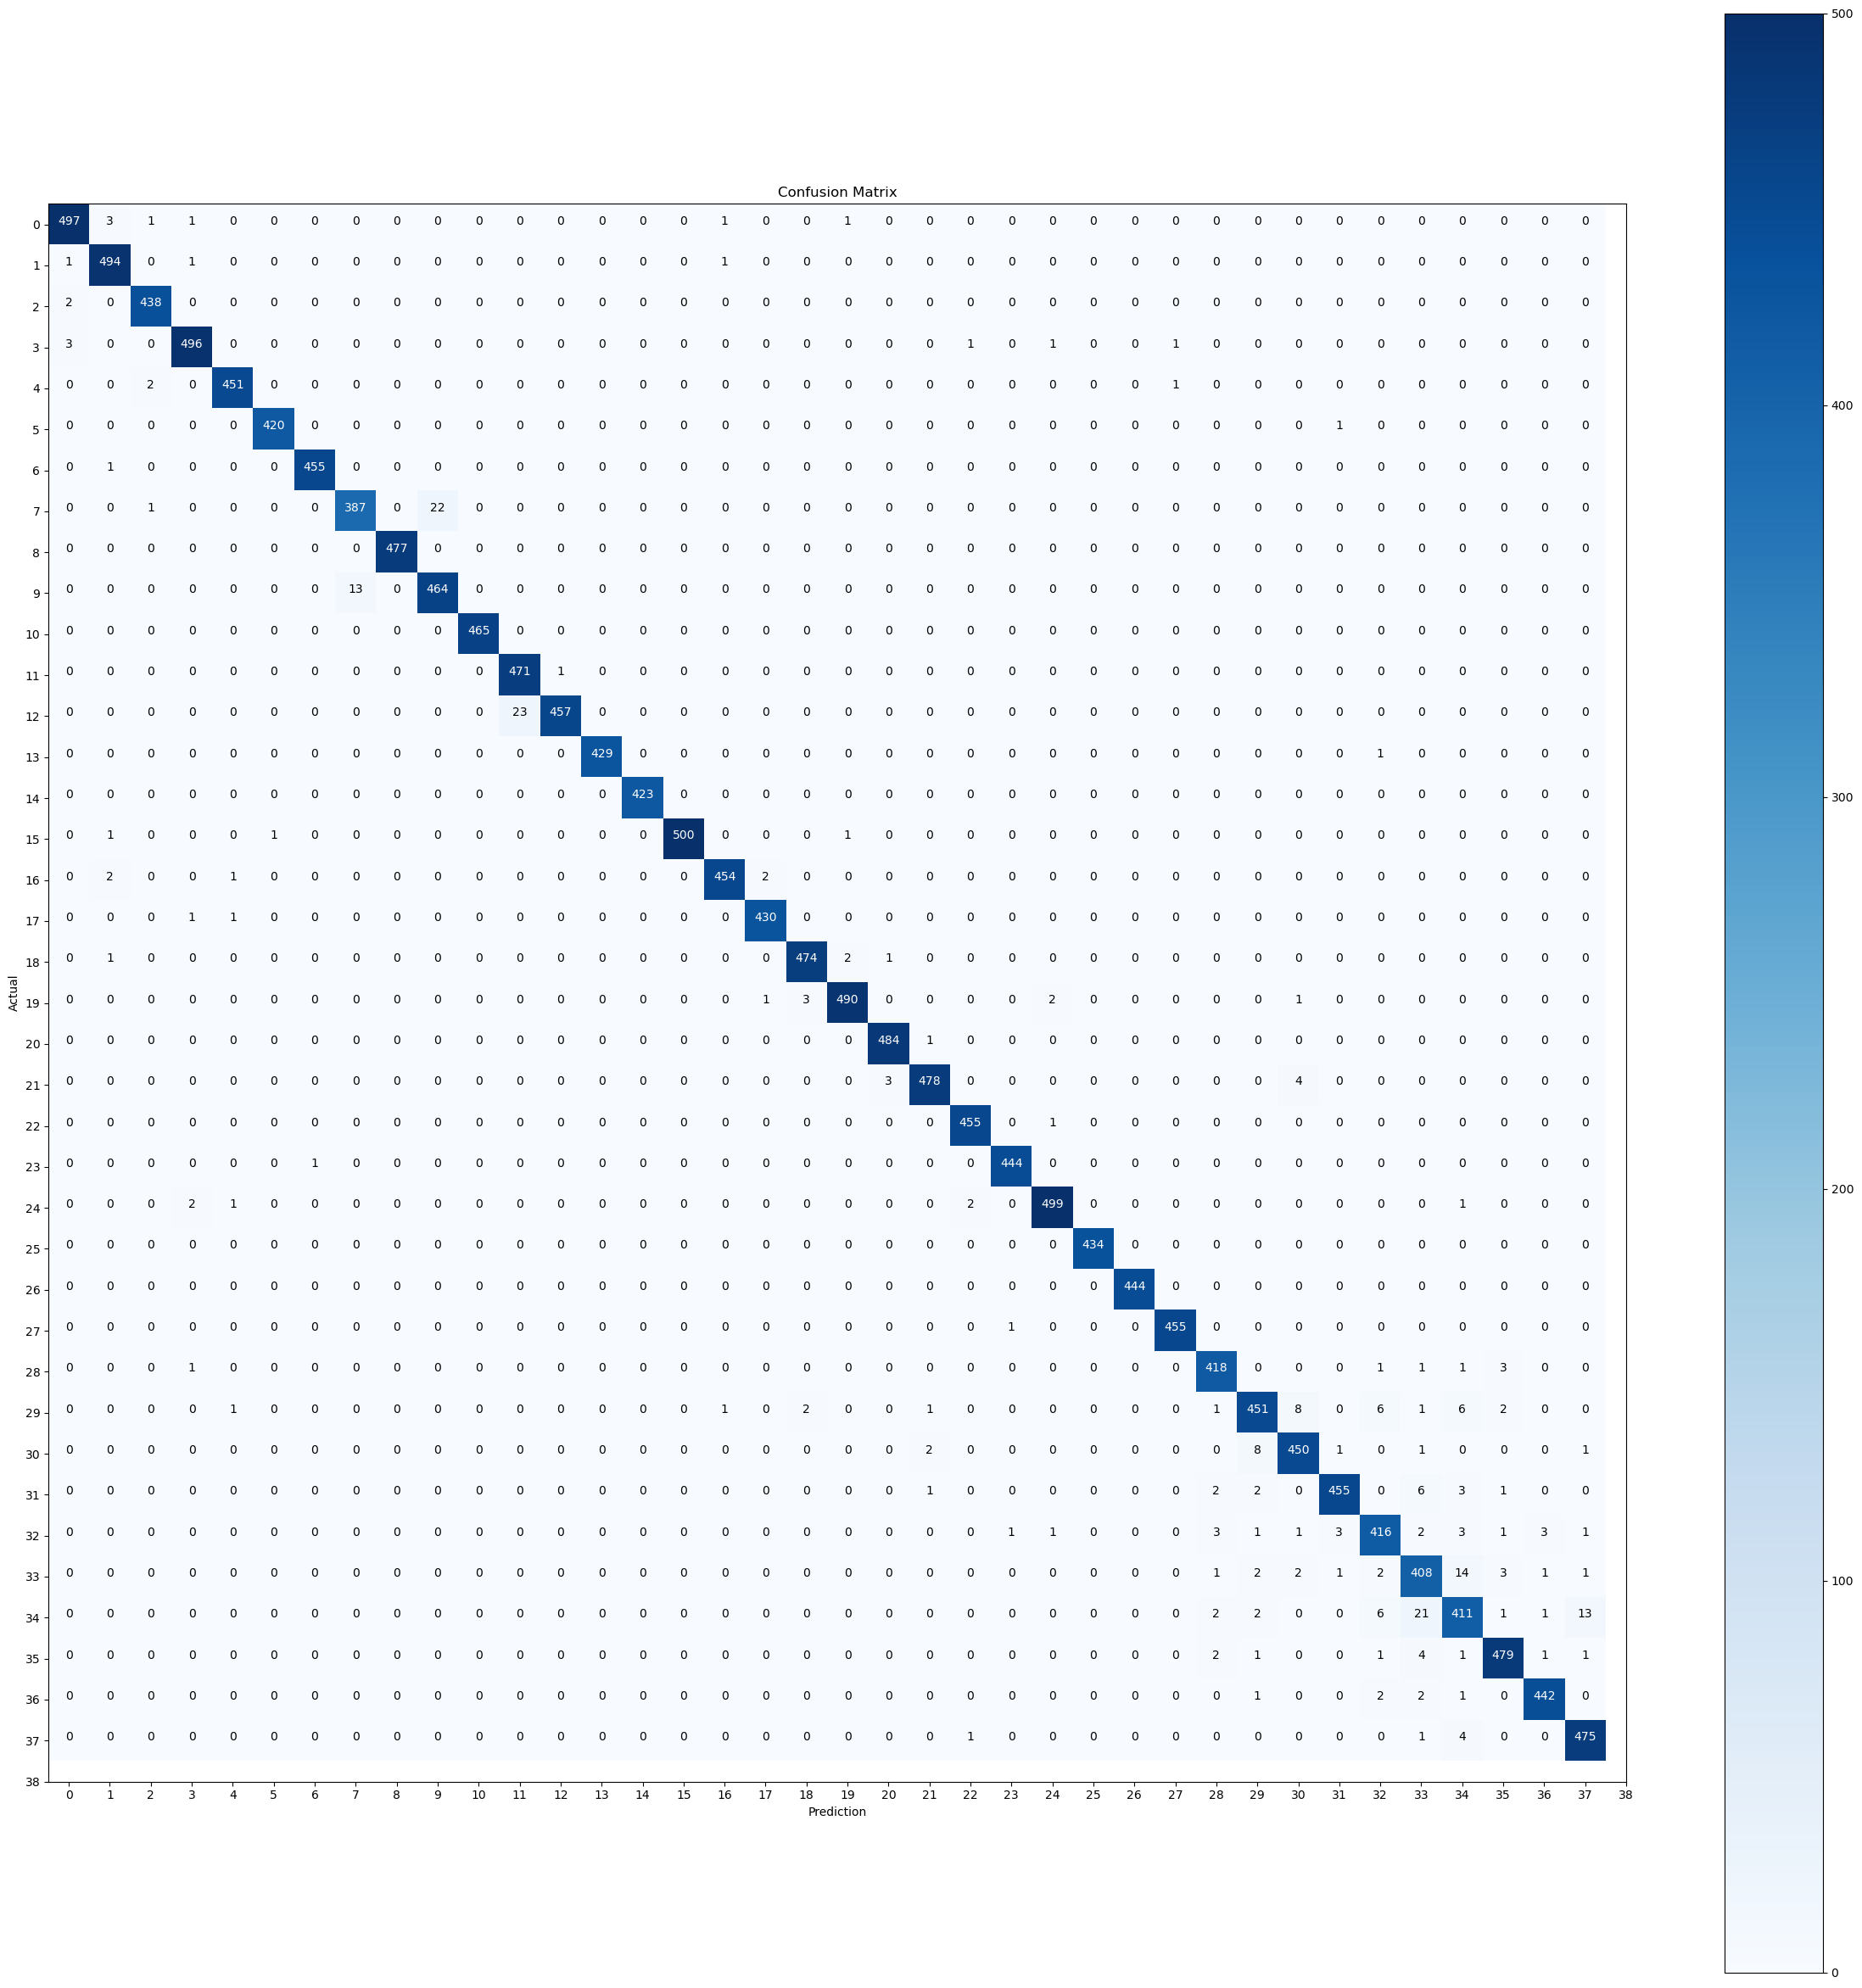

In [25]:
import itertools

classes=range(0,39)
plt.figure(figsize=(30,30))


plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.show()

In [26]:
print(max)

12


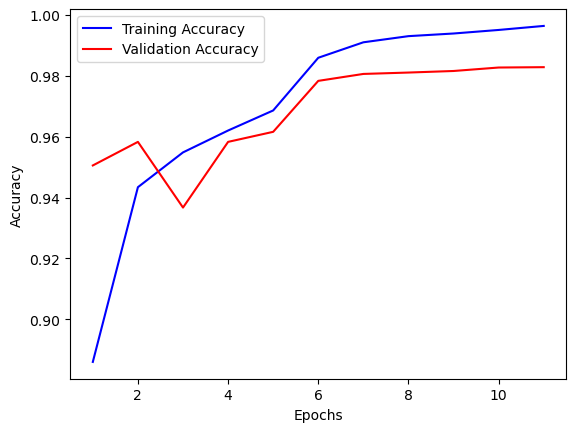

In [27]:
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1,max,1),
         model_history.history['acc'],
         label='Training Accuracy',
         color='blue'
        )

plt.plot(np.arange(1 , max, 1),
         model_history.history['val_acc'], 
         label = 'Validation Accuracy',
         color = 'red')

plt.legend()
plt.show()


In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(11, 7))

for row in range(4):
    for col in range(5):
        indice = np.random.randint(validation_set.shape[0])
        axs[row, col].imshow(X_test[indice].reshape((48,48)), cmap="gray")
        axs[row, col].axis('off')
        axs[row, col].set_title('{} Prédit {}'.format(dict[y_test[indice]], dict[y_pred[indice][0]]))

In [ ]:
next(validation_set)